In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[1])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,OperatorPDEModel
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp, get_gaussianRBF
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, OperatorPDEModel
from functools import partial

from Optimizers.full_jacobian import CholeskyLM, SVD_LM
from Optimizers.solvers_base import *

# import Optimizers
# import importlib
# importlib.reload(Optimizers)
# from Optimizers import CholeskyLM,SVD_LM,SketchedLM

import time
from jax.scipy.sparse.linalg import cg
from jax.scipy.linalg import solve,cho_factor,cho_solve

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results
from matplotlib import ticker

plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_burgers_data(gamma,n_obs, n_coll_t, n_coll_x,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = 2
                                        )
    vec_u0_true_function = np.vectorize(u0_true_function[0])
                            
    # Solve Burgers' equations with IC u_0_true_function
    kappa = 0.01
    alpha = 1.
    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )
    # # Plot
    # num_fine = 500
    # plt.title("True initial and final")
    # grid_points = jnp.linspace(0,1,num_fine)
    # plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine),grid_points]).T),label = 't=0')
    # plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine),grid_points]).T),label = 't=1')
    # plt.legend()
    # plt.show()

    # Collocation point set size
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Collocation point set

    # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    # plot_input_data(
    #     tx_obs,
    #     tx_all,
    #     u_true_function,
    #     tx_fine,
    #             )

    return tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp

## In-sample errors

### 1.5 step method

In [7]:
def get_1_5_error(n_obs,run):
    tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp = get_burgers_data(gamma=2,n_obs=n_obs,n_coll_t=26, n_coll_x=31, run=run)
    # Run 1_5 step method
    # u_operators = (eval_k,)
    u_operators = (eval_k,dx_k,dt_k)
    feature_operators = (eval_k,dx_k,dxx_k)

    # Choose u kernel
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)
    print(1/(jnp.sqrt(ML_lengthscales)))
    k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(log1pexp(fitted_params)))

    # RKHS class for u
    u_model = CholInducedRKHS(
        tx_all,
        u_operators,
        k_u,
        nugget_size = 1e-8
        )
    u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

    grid_features_init = (
        (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
        .reshape(
                len(tx_int),
                len(feature_operators),
                order = 'F'
            )
    )

    # Choose kernel for P
    k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
    @vectorize_kfunc
    def k_P(x,y):
        return k_P_u_part(x[2:],y[2:])
    P_model = OperatorModel(k_P)

    # Equation model that has u and P object
    EqnModel = OperatorPDEModel(
        P_model,
        (u_model,),
        (tx_obs,),
        (u_obs,),
        (tx_int,),
        feature_operators,
        rhs_operator=dt_k,
        datafit_weight = 100
    )
    params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
    optparams = LMParams(max_iter = 201)

    params,convergence_data = CholeskyLM(
        params_init.copy(),
        EqnModel,
        beta = 1e-11,
        optParams = optparams
    )

    p_adjusted,refine_convergence_data = SVD_LM(
        params,
        EqnModel,
        beta = 1e-11,
        optParams = optparams
    )

    u_sol = p_adjusted[:u_model.num_params]
    P_sol = p_adjusted[u_model.num_params:]

    # u_true 
    u_true = u_true_function(tx_fine)
    # get error
    error_u = get_nrmse(u_true, u_model.point_evaluate(tx_fine,u_sol))
    
    num_fine_grid = 100
    t_fine,x_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

    # Estimated P from 1.5 step method
    # input_features = EqnModel.get_stacked_eqn_features((u_sol,)) # before
    input_features = EqnModel.single_eqn_features(u_model,u_sol,tx_int) # now
    Phat = lambda x: P_model.predict_new(x,input_features,P_sol)

    # In-sample
    
    # P[\phi(w)](fine_grid)
    def evaluate_Phat(Phat, interp, fine_grid):

        # Build S_test
        def u_true_function(x):
            return interp(x[:,0],x[:,1],grid = False)
        def ux_true_function(x):
            ux_interp = interp.partial_derivative(0,1)
            return ux_interp(x[:,0],x[:,1],grid = False)
        def uxx_true_function(x):
            uxx_interp = interp.partial_derivative(0,2)
            return uxx_interp(x[:,0],x[:,1],grid = False)
        
        # By hand since the truth is taken as interp from scipy and not an induced RKHS class where we can apply usual feature operators
        feat_funcs = [u_true_function, ux_true_function, uxx_true_function]
        w_features = jnp.array([feat_func(fine_grid) for feat_func in feat_funcs]).T
        fine_features = jnp.hstack([fine_grid, w_features])
        S_test = fine_features
        
        P_preds = Phat(S_test)
        return P_preds

    Phat_u = evaluate_Phat(Phat, interp, tx_fine_int)
    u_t = ut_true_function(tx_fine_int)

    error_Phat = get_nrmse(u_t, Phat_u)

    return error_u, error_Phat

In [14]:
e_ismpl_1_5 = {'u': [], 'Phat':[]}

In [ ]:
N_OBS = [10,30,50,100,200,300,400,500,600]
for n_obs in N_OBS:
    u_errs = []
    P_errs = []
    for run in range(10):
        res = get_1_5_error(n_obs,run)
        u_errs.append(res[0])
        P_errs.append(res[1])
    e_ismpl_1_5['u'].append(u_errs)
    e_ismpl_1_5['Phat'].append(P_errs)
    # Save after
    jnp.save('i_smpl_errors/e_ismpl_1_5', e_ismpl_1_5)

Load data from here

In [16]:
errors_1_5 = jnp.load('i_smpl_errors/e_ismpl_1_5.npy', allow_pickle=True).item()

In [17]:
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_1_5['u']])
u_stds = jnp.array([jnp.std(jnp.array(el)) for el in errors_1_5['u']])
P_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_1_5['Phat']])
P_stds = jnp.array([jnp.std(jnp.array(el)) for el in errors_1_5['Phat']])

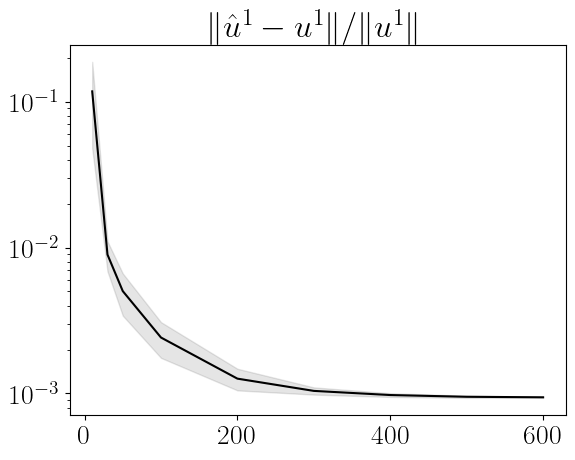

In [22]:
# u errors
N_OBS = [10,30,50,100,200,300,400,500,600]
plt.title(r'$\|\hat{u}^1 - u^1\|/\|u^1\|$')
plt.plot(N_OBS,u_s, color = 'black')
plt.fill_between(N_OBS, u_s - u_stds, u_s + u_stds, alpha=.1, color = 'black')
plt.yscale('log')
plt.show()

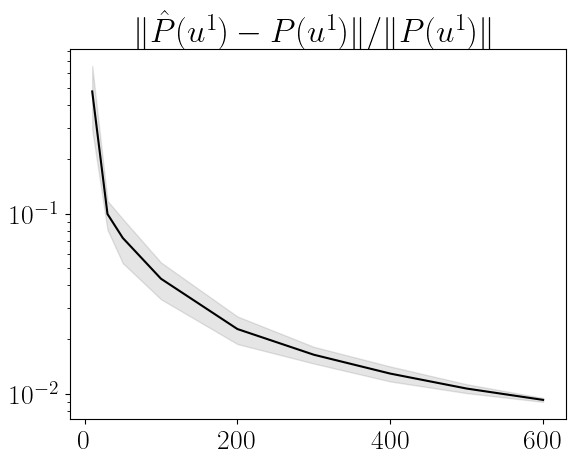

In [23]:
# P errors
N_OBS = [10,30,50,100,200,300,400,500,600]
plt.title(r'$\|\hat{P}(u^1) - P(u^1)\|/\|P(u^1)\|$')
plt.plot(N_OBS,P_s,color = 'black')
plt.fill_between(N_OBS, P_s - P_stds, P_s + P_stds, alpha=.1, color = 'black')
plt.yscale('log')
plt.show()

### SINDy

In [10]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi

In [11]:
def get_SINDy_error(n_obs,run):
    tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp = get_burgers_data(gamma=2,n_obs=n_obs,n_coll_t=26, n_coll_x=31, run=run)
    # Run SINDy
    # u_operators = (eval_k,)
    u_operators = (eval_k,)
    feature_operators = (eval_k,dt_k,dx_k,dxx_k)
    
    # Choose u kernel
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)
    print(1/(jnp.sqrt(ML_lengthscales)))
    k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(log1pexp(fitted_params)))

    # RKHS class for u
    u_model = CholInducedRKHS(
        tx_all,
        u_operators,
        k_u,
        nugget_size = 1e-8
        )
    u_params = u_model.get_fitted_params(tx_obs,u_obs)

    # Get necessary tuples
    u_sol = u_model.get_fitted_params(tx_obs,u_obs)

    S = (u_model.evaluate_operators(feature_operators,tx_int,u_params).reshape(
                len(tx_int), 
                len(feature_operators),
                order = 'F'
                    ))
    
    CONST = jnp.ones(len(S[:,0]))
    U = S[:,0]
    U_t = S[:,1]
    U_x = S[:,2]
    U_xx = S[:,3]
    UU = jnp.multiply(S[:,0],S[:,0])
    UU_x = jnp.multiply(S[:,0],S[:,2])
    UU_xx = jnp.multiply(S[:,0],S[:,3])
    U_xU_x = jnp.multiply(S[:,2],S[:,2])
    U_xU_xx = jnp.multiply(S[:,2],S[:,3])
    U_xxU_xx = jnp.multiply(S[:,3],S[:,3])
    
    

    Theta = jnp.vstack([CONST,U,U_x,U_xx,
                        UU,UU_x,UU_xx,U_xU_x,
                        U_xU_xx,U_xxU_xx]).T


    res_SINDy = sparsifyDynamics(Theta,U_t.reshape(-1,1),lamb = 1e-8, n = 1)

    # u_true 
    u_true = u_true_function(tx_fine)
    # get error
    error_u = get_nrmse(u_true, u_model.point_evaluate(tx_fine,u_sol))
    
    num_fine_grid = 100
    t_fine,x_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

    
    def Phat(s,coeffs):
        return jnp.dot(s,coeffs)

    # In-sample
        
    # P[\phi(w)](fine_grid)
    def evaluate_Phat(Phat, interp, fine_grid):

        # Build S_test
        def one_func(x):
            return jnp.ones(len(x))
        def u_true_function(x):
            return interp(x[:,0],x[:,1],grid = False)
        def ux_true_function(x):
            ux_interp = interp.partial_derivative(0,1)
            return ux_interp(x[:,0],x[:,1],grid = False)
        def uxx_true_function(x):
            uxx_interp = interp.partial_derivative(0,2)
            return uxx_interp(x[:,0],x[:,1],grid = False)
        def uu_true_function(x):
            return u_true_function(x)**2
        def uux_true_function(x):
            return u_true_function(x)*ux_true_function(x)
        def uuxx_true_function(x):
            return u_true_function(x)*uxx_true_function(x)
        def uxux_true_function(x):
            return ux_true_function(x)*ux_true_function(x)
        def uxuxx_true_function(x):
            return ux_true_function(x)*uxx_true_function(x)
        def uxxuxx_true_function(x):
            return uxx_true_function(x)*uxx_true_function(x)
    
        
        # By hand since the truth is taken as interp from scipy and not an induced RKHS class where we can apply usual feature operators
        feat_funcs = [one_func,u_true_function, ux_true_function, uxx_true_function,
                      uu_true_function,uux_true_function,uuxx_true_function,
                      uxux_true_function,uxuxx_true_function,uxxuxx_true_function]
        fine_features = jnp.array([feat_func(fine_grid) for feat_func in feat_funcs]).T
        S_test = fine_features
        
        P_preds = Phat(S_test,res_SINDy)
        return P_preds

    Phat_u = evaluate_Phat(Phat, interp, tx_fine_int)
    u_t = ut_true_function(tx_fine_int)

    error_Phat = get_nrmse(u_t, Phat_u.flatten())

    return error_u, error_Phat

In [26]:
e_ismpl_SINDy = {'u': [], 'Phat':[]}

In [ ]:
N_OBS = [10,30,50,100,200,300,400,500,600]
for n_obs in N_OBS:
    u_errs = []
    P_errs = []
    for run in range(10):
        res = get_SINDy_error(n_obs,run)
        u_errs.append(res[0])
        P_errs.append(res[1])
    e_ismpl_SINDy['u'].append(u_errs)
    e_ismpl_SINDy['Phat'].append(P_errs)
    # Save after
    jnp.save('i_smpl_errors/e_ismpl_SINDy', e_ismpl_SINDy)

Load from here

In [28]:
errors_SINDy = jnp.load('i_smpl_errors/e_ismpl_SINDy.npy', allow_pickle=True).item()

In [29]:
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_SINDy['u']])
u_stds = jnp.array([jnp.std(jnp.array(el)) for el in errors_SINDy['u']])
P_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_SINDy['Phat']])
P_stds = jnp.array([jnp.std(jnp.array(el)) for el in errors_SINDy['Phat']])

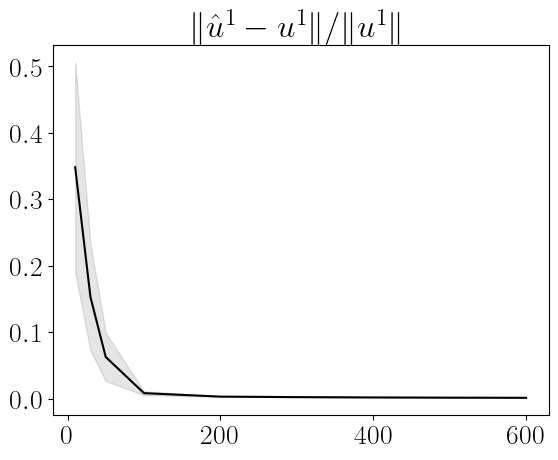

In [30]:
# u errors
N_OBS = [10,30,50,100,200,300,400,500,600]
plt.title(r'$\|\hat{u}^1 - u^1\|/\|u^1\|$')
plt.plot(N_OBS,u_s, color = 'black')
plt.fill_between(N_OBS, u_s - u_stds, u_s + u_stds, alpha=.1, color = 'black')
plt.show()

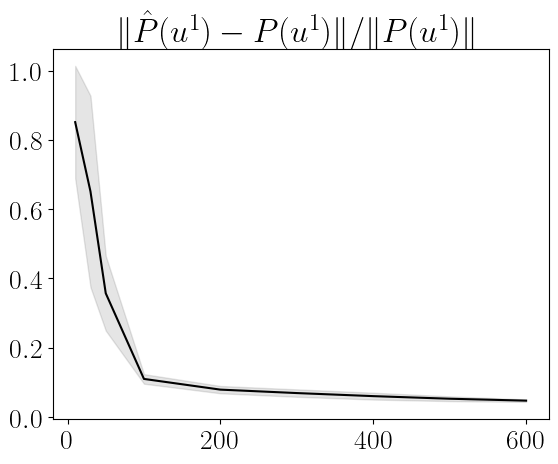

In [31]:
# P errors
N_OBS = [10,30,50,100,200,300,400,500,600]
plt.title(r'$\|\hat{P}(u^1) - P(u^1)\|/\|P(u^1)\|$')
plt.plot(N_OBS,P_s,color = 'black')
plt.fill_between(N_OBS, P_s - P_stds, P_s + P_stds, alpha=.1, color = 'black')
# plt.yscale('log')
plt.show()

### PINNSR

In [15]:
def get_data_for_pinns(gamma,n_obs, n_coll_t, n_coll_x,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            #seed = run
                                            seed = 2
                                        )
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    
    # Solve Burgers' equations with IC u_0_true_function
    kappa = 0.01
    alpha = 1.
    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha, k_timestep=0.0001,n_finite_diff=1999)
                        )
    
    # # Plot
    # num_fine = 500
    # plt.title("True initial and final")
    # grid_points = jnp.linspace(0,1,num_fine)
    # plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine),grid_points]).T),label = 't=0')
    # plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine),grid_points]).T),label = 't=1')
    # plt.legend()
    # plt.show()

    # Collocation point set
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    
    # Invert them to be ready for PINNSR 
    tx_train = tx_obs
    u_train = u_true_function(tx_train)
    tx_val = jax.random.choice(key = jax.random.PRNGKey(0), a = tx_fine, shape = (int(jnp.ceil(tx_train.shape[0]*(1-0.8)/0.8)),), replace=False)
    # plt.scatter(*tx_val.T,c = 'green')
    u_val = u_true_function(tx_val)
    lb = tx_fine.min(0)
    ub = tx_fine.max(0)
    
    # plot_input_data(
    #     tx_train, 
    #     tx_all,
    #     u_true_function,
    #     tx_fine,
    #             )
    
    # def plot_input_data(
    #     obs_points,
    #     all_points,
    #     func_to_plot,
    #     fine_grid,
    #     xlabel = r'$t$',
    #     ylabel = r'$x$',
    #     include_collocation = True
    # ):
    #     plt.figure(figsize=(8,6))

    #     x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
    #     y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
    #     plt.tricontourf(fine_grid[:,0],fine_grid[:,1],func_to_plot(fine_grid),200)
    #     cb = plt.colorbar()
    #     tick_locator = ticker.MaxNLocator(nbins=4)
    #     cb.locator = tick_locator
    #     cb.update_ticks()
    #     plt.xlabel(xlabel)
    #     plt.ylabel(ylabel)
    #     plt.xlim(x_bounds[0] - 0.02,x_bounds[1] + 0.02)
    #     plt.ylim(y_bounds[0] - 0.02,y_bounds[1] + 0.02)
    #     plt.scatter(obs_points[:,0],obs_points[:,1],c='red', s = 50, alpha = 0.5,label = "Function Value Observed")
    #     if include_collocation is True:
    #         plt.scatter(all_points[:,0],all_points[:,1],c='gray',s = 5,label = "Collocation Point")
    #     #plt.figlegend(loc = 'upper center')


    # plot_input_data(
    #     tx_obs,
    #     tx_all,
    #     u_true_function,
    #     tx_fine,
    # )
    # plt.gca().spines['bottom'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)
    # plt.gca().spines['left'].set_visible(False)
    # plt.gca().spines['top'].set_visible(False)
    # plt.tight_layout()
    # plt.locator_params(nbins=4)
    # plt.savefig('burgers_smooth',dpi = 300)
    # plt.show()

    # plt.figure(figsize=(7,6))
    # num_fine_grid = 500
    # grid_points = jnp.linspace(0,1,num_fine_grid)
    # plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),color = 'black',label = r'$t=0$')
    # plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),linestyle = '--',color = 'black',label = r'$t=1$')
    # # Number of tick major labels
    # plt.locator_params(axis="x", nbins=4)
    # plt.locator_params(axis="y", nbins=4)
    # # Remove top and right spines
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)
    # # More settings
    # plt.xlabel('$x$')
    # plt.ylabel('$u(t,x)$')
    # plt.legend(loc="upper right",fontsize = 'x-small')
    # plt.tight_layout()
    # plt.savefig('burgers_smooth_init_final',dpi = 300)
    # plt.show()


    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

    tx_all = jnp.vstack([tx_all,tx_train])

    

    return [tx_train, u_train, tx_all, tx_val, u_val, lb, ub]

In [ ]:
q = get_data_for_pinns(gamma=2,n_obs=20, n_coll_t=26, n_coll_x=31,run=0)

#### Generate data

In [ ]:
data_in_PINNSR = []
# Run loop
NUM_RUNS = 10
N_OBS = [10,30,50,100,200,300,400,500,600]
for n_obs in N_OBS:
    for run in range(NUM_RUNS):
        element = []
        element.append(n_obs)
        element.append(run)
        # Run
        data_list = get_data_for_pinns(gamma=2,n_obs=n_obs, n_coll_t=26, n_coll_x=31,run=run) # small
        # data_list = get_data_for_pinns(gamma=2,n_obs=n_obs, n_coll_t=223, n_coll_x=225,run=run)
        data_list = list(map(np.array,data_list))
        element.append(data_list)
        data_in_PINNSR.append(element)
np.save('data_in_PINNSR.npy', np.array(data_in_PINNSR, dtype=object), allow_pickle=True)

In [18]:
data_in_PINNSR =  np.load('data_in_PINNSR.npy', allow_pickle=True)

In [24]:
data_in_PINNSR[0][2][2].shape

(50854, 2)

Read out coefficients by PINNSR

In [3]:
data_out_PINNSR = np.load('data_out_PINNSR.npy', allow_pickle=True)

In [8]:
for element in data_out_PINNSR:
    if isinstance(element[2],str):
        print(element[0],element[1])

In [14]:
for element in data_out_PINNSR:
    if element[0]==30 and element[1]==0:
        num_fine_grid = 100
        t_fine,x_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
        tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T
        plt.title('u_pred_PINNSR50kcoll')
        plt.tricontourf(*tx_fine_int.T,element[3].flatten(),200)
        plt.colorbar()
        plt.xlabel('t')
        plt.ylabel('x')

In [16]:
def get_PINNSR_error(n_obs,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = 2,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = 2
                                        )
    vec_u0_true_function = np.vectorize(u0_true_function[0])
                            
    # Solve Burgers' equations with IC u_0_true_function
    kappa = 0.01
    alpha = 1.
    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )
    
    # Run PINNSR step method
    data_out_PINNSR = np.load('data_out_PINNSR.npy', allow_pickle=True)
    for element in data_out_PINNSR:
        if element[0] == n_obs and element[1] == run and isinstance(element[2],str) == False:
            coef = jnp.array(element[2].flatten().astype(np.float64))
            u_pred = jnp.array(element[3].flatten().astype(np.float64))
        elif element[0] == n_obs and element[1] == run and isinstance(element[2],str) == True:
            return np.nan, np.nan
        else:
            pass
            
    
    num_fine_grid = 100
    t_fine,x_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

    
    def Phat(s):
        return jnp.dot(s,coef)

    # In-sample
        
    # P[\phi(w)](fine_grid)
    def evaluate_Phat(Phat, interp, fine_grid):

        # Build S_test
        def one_func(x):
            return jnp.ones(len(x))
        def u_true_function(x):
            return interp(x[:,0],x[:,1],grid = False)
        def ux_true_function(x):
            ux_interp = interp.partial_derivative(0,1)
            return ux_interp(x[:,0],x[:,1],grid = False)
        def uxx_true_function(x):
            uxx_interp = interp.partial_derivative(0,2)
            return uxx_interp(x[:,0],x[:,1],grid = False)
        def uu_true_function(x):
            return u_true_function(x)**2
        def uux_true_function(x):
            return u_true_function(x)*ux_true_function(x)
        def uuxx_true_function(x):
            return u_true_function(x)*uxx_true_function(x)
        def uxux_true_function(x):
            return ux_true_function(x)*ux_true_function(x)
        def uxuxx_true_function(x):
            return ux_true_function(x)*uxx_true_function(x)
        def uxxuxx_true_function(x):
            return uxx_true_function(x)*uxx_true_function(x)
    
        
        # By hand since the truth is taken as interp from scipy and not an induced RKHS class where we can apply usual feature operators
        feat_funcs = [one_func,u_true_function, ux_true_function, uxx_true_function,
                      uu_true_function,uux_true_function,uuxx_true_function,
                      uxux_true_function,uxuxx_true_function,uxxuxx_true_function]
        fine_features = jnp.array([feat_func(fine_grid) for feat_func in feat_funcs]).T
        S_test = fine_features
        
        P_preds = Phat(S_test)
        return P_preds

    Phat_u = evaluate_Phat(Phat, interp, tx_fine_int)
    u_t = ut_true_function(tx_fine_int)

    # u error
    num_fine_grid = 100
    t_fine,x_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T
    # u_true 
    u_true = u_true_function(tx_fine_int)
    # get error
    error_u = get_nrmse(u_true, u_pred)
    
    # fig = plt.figure()
    # plt.title('P error')
    # plt.tricontourf(*tx_fine_int.T,(Phat_u.flatten() - u_t)/jnp.linalg.norm(u_t))
    # plt.colorbar()

    error_Phat = get_nrmse(u_t, Phat_u.flatten())

    return error_u, error_Phat

In [4]:
e_ismpl_PINNSR = {'u': [], 'Phat':[]}

In [ ]:
N_OBS = [10,30,50,100,200,300,400,500,600]
N_RUNS = 10
for n_obs in N_OBS:
    u_errs = []
    P_errs = []
    for run in range(N_RUNS):
        res = get_PINNSR_error(n_obs,run)
        u_errs.append(res[0])
        P_errs.append(res[1])
    e_ismpl_PINNSR['u'].append(u_errs)
    e_ismpl_PINNSR['Phat'].append(P_errs)

In [6]:
# Save after
jnp.save('i_smpl_errors/e_ismpl_PINNSR', e_ismpl_PINNSR)

Load from here

In [7]:
errors_PINNSR = jnp.load('i_smpl_errors/e_ismpl_PINNSR.npy', allow_pickle=True).item()

In [8]:
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in e_ismpl_PINNSR['u']])
u_stds = jnp.array([jnp.std(jnp.array(el)) for el in e_ismpl_PINNSR['u']])
P_s = jnp.array([jnp.nanmean(jnp.array(el)) for el in errors_PINNSR['Phat']])
P_stds = jnp.array([jnp.nanstd(jnp.array(el)) for el in errors_PINNSR['Phat']])

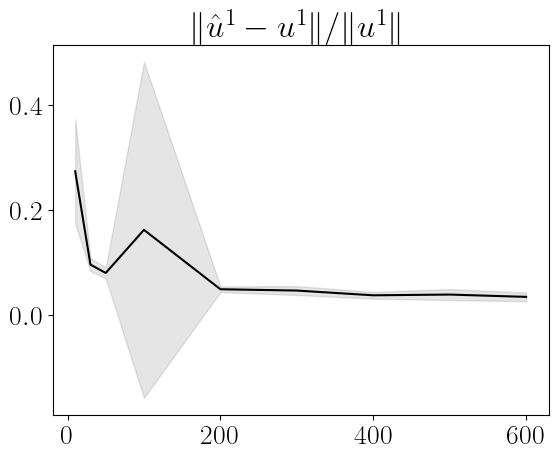

In [10]:
# u errors
N_OBS = [10,30,50,100,200,300,400,500,600]
plt.title(r'$\|\hat{u}^1 - u^1\|/\|u^1\|$')
plt.plot(N_OBS,u_s, color = 'black')
plt.fill_between(N_OBS, u_s - u_stds, u_s + u_stds, alpha=.1, color = 'black')
plt.show()

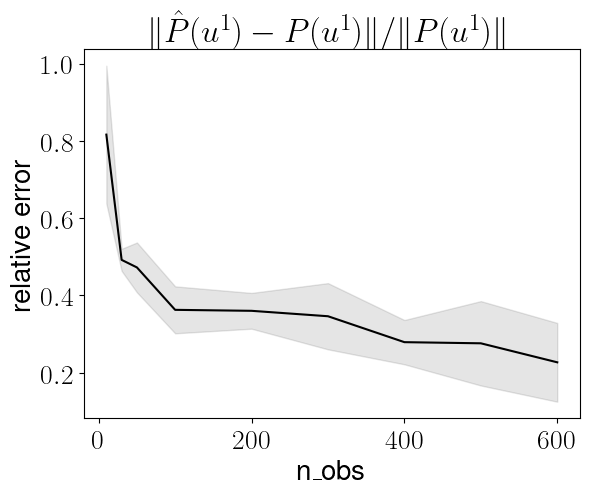

In [11]:
# P errors
N_OBS = [10,30,50,100,200,300,400,500,600]
plt.title(r'$\|\hat{P}(u^1) - P(u^1)\|/\|P(u^1)\|$')
plt.plot(N_OBS,P_s,color = 'black')
plt.fill_between(N_OBS, P_s - P_stds, P_s + P_stds, alpha=.1, color = 'black')
plt.xlabel('n_obs')
plt.ylabel('relative error')
# plt.yscale('log')
plt.show()

### Final results

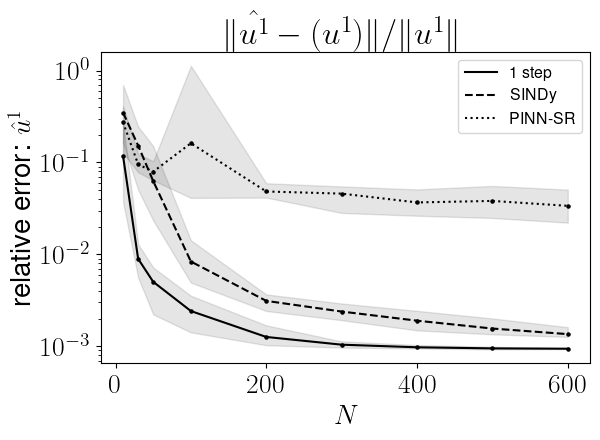

In [4]:
# U PLOT ERROR CURVE
N_OBS = [10,30,50,100,200,300,400,500,600]
##### 1 step
errors_1_5 = jnp.load('i_smpl_errors/e_ismpl_1_5.npy', allow_pickle=True).item()
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_1_5['u']])
u_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_1_5['u']])
u_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_1_5['u']])
plt.plot(N_OBS,u_s, color = 'black', label = '1 step')
plt.scatter(N_OBS,u_s, s = 5, color = 'black')
plt.fill_between(N_OBS, u_lower, u_upper, alpha=.1, color = 'black')
##### SINDy
errors_SINDy = jnp.load('i_smpl_errors/e_ismpl_SINDy.npy', allow_pickle=True).item()
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_SINDy['u']])
u_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_SINDy['u']])
u_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_SINDy['u']])
plt.plot(N_OBS,u_s,color = 'black', label = 'SINDy',linestyle='dashed')
plt.scatter(N_OBS,u_s,s = 5, color = 'black')
plt.fill_between(N_OBS, u_lower, u_upper, alpha=.1, color = 'black')
##### PINNSR
errors_PINNSR = jnp.load('i_smpl_errors/e_ismpl_PINNSR.npy', allow_pickle=True).item()
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_PINNSR['u']])
u_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_PINNSR['u']])
u_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_PINNSR['u']])
plt.plot(N_OBS,u_s,color = 'black', label = 'PINN-SR',linestyle='dotted')
plt.scatter(N_OBS,u_s,s = 5, color = 'black')
plt.fill_between(N_OBS, u_lower, u_upper, alpha=.1, color = 'black')

#### Settings of the plot
plt.title(r'$\|\hat{u^1} - (u^1)\|/\|u^1\|$')
plt.xlabel('$N$')
plt.ylabel(r'relative error: $\hat{u}^1$')
plt.yscale('log')
plt.legend(fontsize='xx-small',loc='upper right')
plt.tight_layout()
plt.savefig('Burgers_u_error_ismplp',dpi=300)
plt.show()

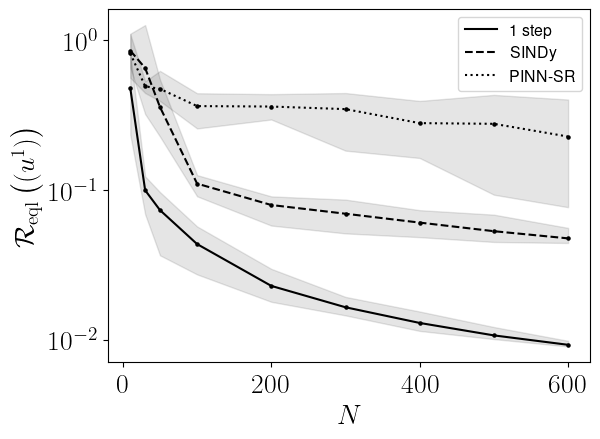

In [20]:
# P PLOT ERROR CURVE
N_OBS = [10,30,50,100,200,300,400,500,600]
##### 1 step
errors_1_5 = jnp.load('i_smpl_errors/e_ismpl_1_5.npy', allow_pickle=True).item()
P_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_1_5['Phat']])
P_lower = jnp.array([jnp.min(jnp.array(el)) for el in errors_1_5['Phat']])
P_upper = jnp.array([jnp.max(jnp.array(el)) for el in errors_1_5['Phat']])
plt.plot(N_OBS,P_s,color = 'black', label = '1 step')
plt.scatter(N_OBS,P_s,s = 5, color = 'black')
plt.fill_between(N_OBS, P_lower, P_upper, alpha=.1, color = 'black')
##### SINDy
errors_SINDy = jnp.load('i_smpl_errors/e_ismpl_SINDy.npy', allow_pickle=True).item()
P_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_SINDy['Phat']])
P_lower = jnp.array([jnp.min(jnp.array(el)) for el in errors_SINDy['Phat']])
P_upper = jnp.array([jnp.max(jnp.array(el)) for el in errors_SINDy['Phat']])
plt.plot(N_OBS,P_s,color = 'black', label = 'SINDy',linestyle='dashed')
plt.scatter(N_OBS,P_s,s = 5, color = 'black')
plt.fill_between(N_OBS, P_lower, P_upper, alpha=.1, color = 'black')
##### PINNSR
errors_PINNSR = jnp.load('i_smpl_errors/e_ismpl_PINNSR.npy', allow_pickle=True).item()
P_s = jnp.array([jnp.nanmean(jnp.array(el)) for el in errors_PINNSR['Phat']])
P_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_PINNSR['Phat']])
P_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_PINNSR['Phat']])
plt.plot(N_OBS,P_s,color = 'black', label = 'PINN-SR',linestyle='dotted')
plt.scatter(N_OBS,P_s,s = 5, color = 'black')
plt.fill_between(N_OBS, P_lower, P_upper, alpha=.1, color = 'black')

#### Settings of the plot
# plt.title(r'$\|\hat{P}(u^1) - P(u^1)\|/\|P(u^1)\|$')
plt.xlabel('$N$')
plt.ylabel(r'$\mathcal{R}_{\rm{eql}} \left((u^1)\right)$')
plt.yscale('log')
plt.legend(fontsize='xx-small',loc='upper right')
plt.tight_layout()
plt.minorticks_off()
plt.savefig('Burgers_P_error_ismplp.pdf',dpi=300, format = 'pdf')
plt.show()